# SIR Simulation

In [1]:
# Required packages
using Distances,
      Pathogen,
      Random

# Set seed
Random.seed!(4321)

MersenneTwister(UInt32[0x000010e1], Random.DSFMT.DSFMT_state(Int32[828207708, 1072963603, 944777159, 1073116825, -1874604190, 1073592723, 1895843842, 1072889867, 417980119, 1073435448  …  942511690, 1072922716, -272694346, 1073598557, 447711889, -1950062523, -1735217658, -228949619, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000000

In [2]:
# Generate population
n = 100
risks = DataFrame(x = rand(Uniform(0, 15), n),
                  y = rand(Uniform(0, 30), n),
                  riskfactor1 = rand(Gamma(), n))

# Precalculate distances
dists = [euclidean([risks[i, :x];
                    risks[i, :y]],
                   [risks[j, :x];
                    risks[j, :y]]) for i = 1:n, j = 1:n]

pop = Population(risks, dists)

Population object (n=100)

In [3]:
# Define risk functions/TN-ILM structure
function _constant(params::Vector{Float64}, pop::Population, i::Int64)
  return params[1]
end

function _one(params::Vector{Float64}, pop::Population, i::Int64)
  return 1.0
end

function _linear(params::Vector{Float64}, pop::Population, i::Int64)
  return params[1] * pop.risks[i, :riskfactor1]
end

function _powerlaw(params::Vector{Float64}, pop::Population, i::Int64, k::Int64)
  β = params[1]
  d = pop.distances[k, i]
  return d^(-β)
end

rf = RiskFunctions{SIR}(_constant, # sparks function
                        _one, # susceptibility function
                        _powerlaw, # infectivity function
                        _one, # transmissability function
                        _linear) # removal function

# Parametrize risk functions for simulation
rparams = RiskParameters{SIR}([0.0001], # sparks function parameter(s)
                              Float64[], # susceptibility function parameter(s)
                              [4.0], # infectivity function parameter(s)
                              Float64[], # transmissibility function parameter(s)
                              [0.1]) # removal function parameter(s)

SIR model risk function parameters

In [4]:
# Set starting states in population
# Set first individual as infectious, others as susceptible to start
starting_states = [State_I; fill(State_S, n-1)]

# Initialize Simulation
sim = Simulation(pop, starting_states, rf, rparams)

# Simulate!
simulate!(sim, tmax=200.0)

SIR epidemic simulation @ time = 200.0

S = 1
I = 3
R = 96

In [5]:
using Plots, 
      Plots.PlotMeasures

gr(dpi=200)

# Epidemic Curve
p1 = plot(sim.events, 0.0, 200.0, legendfont=font(6), xaxis=font(10), bottom_margin=30px)

# Population/TransmissionNetwork plots
p2=plot(sim.transmission_network, sim.population, sim.events, 0.0, title="Time = 0", titlefontsize = 8)
p3=plot(sim.transmission_network, sim.population, sim.events, 50.0, title="Time = 50", titlefontsize = 8)
p4=plot(sim.transmission_network, sim.population, sim.events, 100.0, title="Time = 100", titlefontsize = 8)
p5=plot(sim.transmission_network, sim.population, sim.events, 150.0, title="Time = 150", titlefontsize = 8)
p6=plot(sim.transmission_network, sim.population, sim.events, 200.0, title="Time = 200", titlefontsize = 8)
l = @layout [a;
             b c d e f]
combinedplots1 = plot(p1, p2, p3, p4, p5, p6, layout=l)
png(combinedplots1, joinpath(@__DIR__, "epiplot.png"))

![Epidemic Visualization](epiplot.png)

┌ Info: Saved animation to 
│   fn = /Users/justin/.julia/dev/Pathogen/examples/SIR Simulation/epianimation.gif
└ @ Plots /Users/justin/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/Users/justin/.julia/dev/Pathogen/examples/SIR Simulation/epianimation.gif")
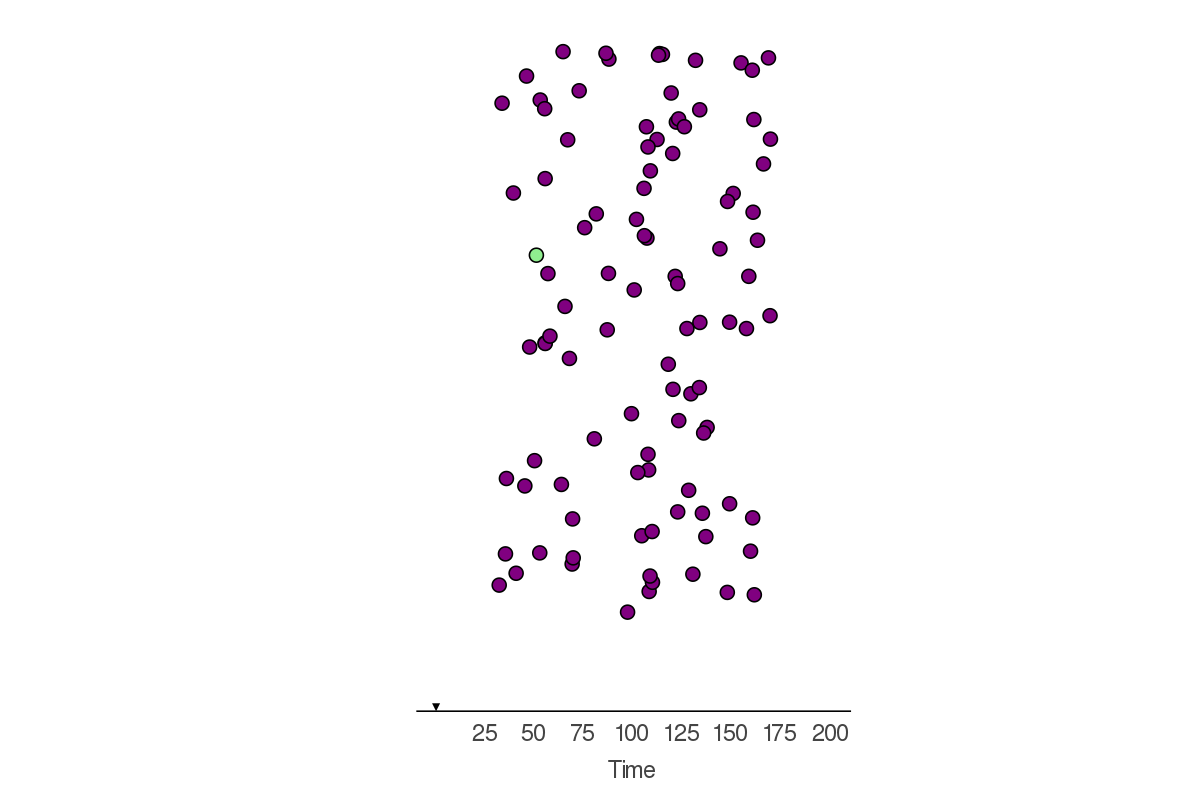

In [6]:
# Transmission animation
anim = @animate for simtime = range(0.0, 200.0, step=1.0)
    p1 = plot(sim.transmission_network, sim.population, sim.events, simtime, markersize=4, legend=:none, xlim=(-2,17))
    p2=plot([simtime], [1.0], seriestype=:scatter, markercolor=:black, markersize=4, marker=:dtriangle, legend=:none, xlabel="Time", framestyle=:origin, grid=:none, tick_direction=:out, yaxis=false, xticks=0:25:200, aspect_ratio=4, ylim=(-1,1), xlim=(-10,210), xaxis=font(8))
    l = @layout [a{0.975h}; b]   
    plot(p1, p2, layout=l)
end
gif(anim, joinpath(@__DIR__, "epianimation.gif"), fps = 20)

![Epidemic Animation](epianimation.gif)

In [7]:
# Generate observations with Uniform(0.5, 2.5) observation delay for infection and removal
obs = observe(sim, Uniform(0.5, 2.5), Uniform(0.5, 2.5), force=true)

# Optimistically assume we know the functional form of epidemic (i.e. use same risk functions used for simulation purposes)
# Specify some priors for the risk parameters of our various risk functions
rpriors = RiskPriors{SIR}([Exponential(0.0001)],
                          UnivariateDistribution[],
                          [Uniform(1.0, 7.0)],
                          UnivariateDistribution[],
                          [Uniform(0.0, 1.0)])

# Set some extents for event data augmentation
ee = EventExtents{SIR}(5.0, 5.0)

SIR model event extents

In [8]:
# Initialize MCMC
mcmc = MCMC(obs, ee, pop, starting_states, rf, rpriors)
start!(mcmc, attempts=50000) # 1 chain, with 50k initialization attempts

# Run MCMC
iterate!(mcmc, 50000, 1.0, condition_on_network=true, event_batches=5)

Initialization progress100%|████████████████████████████| Time: 0:00:44m
MCMC progress100%|██████████████████████████████████████| Time: 0:19:24m


SIR model MCMC with 1 chains

In [9]:
# MCMC and posterior plots
p1 = plot(1:20:50001,
  mcmc.markov_chains[1].risk_parameters, yscale=:log10, title="TN-ILM parameters", xguidefontsize=8, yguidefontsize=8, xtickfontsize=7, ytickfontsize=7, titlefontsize=11, bottom_margin=30px)

p2 = plot(mcmc.markov_chains[1].events[10000], State_S,
          linealpha=0.01, title="S", xguidefontsize=8, yguidefontsize=8,
          xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=10020:20:50000
  plot!(p2, mcmc.markov_chains[1].events[i], State_S, linealpha=0.01)
end
plot!(p2, sim.events, State_S, linecolor=:black, linewidth=1.5)

p3 = plot(mcmc.markov_chains[1].events[10000], State_I,
          linealpha=0.01, title="I", xguidefontsize=8, yguidefontsize=8, xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=10020:20:50000
  plot!(p3, mcmc.markov_chains[1].events[i], State_I, linealpha=0.01)
end
plot!(p3, sim.events, State_I, linecolor=:black, linewidth=1.5)

p4 = plot(mcmc.markov_chains[1].events[10000], State_R,
          linealpha=0.01, title="R", xguidefontsize=8, yguidefontsize=8, xtickfontsize=7, ytickfontsize=7, titlefontsize=11)
for i=10020:20:50000
  plot!(p4, mcmc.markov_chains[1].events[i], State_R, linealpha=0.01)
end
plot!(p4, sim.events, State_R, linecolor=:black, linewidth=1.5)

l = @layout [a; [b c d]]
combinedplots2 = plot(p1, p2, p3, p4, layout=l)
png(combinedplots2, joinpath(@__DIR__, "posterior.png"))

![Posterior](posterior.png)

In [10]:
p1 = plot(sim.transmission_network, sim.population, title="True Transmission\nNetwork", titlefontsize=11, framestyle=:box)

tnp = TransmissionNetworkPosterior(mcmc.markov_chains[1].transmission_network[10000:20:50000])
p2 = plot(tnp, sim.population, title="Transmission Network\nPosterior Distribution", titlefontsize=11, framestyle=:box)

combinedplots3 = plot(p1, p2, layout=(1, 2))
png(combinedplots3, joinpath(@__DIR__, "posterior_tn.png"))

![Transmission Posterior](posterior_tn.png)

In [11]:
summary(mcmc, burnin=10000, thin=20)

,parameter,mean,var,credible99,credible95
,String,Float64,Float64,Tuple…,Tuple…
1,ϵ₁,9.77226e-5,8.89031e-9,"(3.85894e-7, 0.000504902)","(2.41738e-6, 0.000345974)"
2,κ₁,3.46281,0.00366586,"(3.26929, 3.59936)","(3.326, 3.56915)"
3,Ωr₁,0.0884437,7.91009e-5,"(0.0685448, 0.112733)","(0.0720924, 0.106076)"
